# Differentiable Physics I:  Verlet Integration

## Forward Integration of Newton's Equations of Motion

Given a particle with:

- position $x$ 
- mass $m$ 
- velocity $v$ = $\frac{dx}{dt}$ 
- acceleration $a$ = $\frac{dv}{dt}$ = $\frac{d^2x}{dt^2}$
- force $F$ 

For a simple example, we apply the second motion $ F = m \frac{d^2 x}{dt^2} $ along with Hooke's Law $F(x) = -k x$. This results in the following differential equation:

$$ m a = -k x \\
\frac{d^2x}{dt^2} = \frac{-k}{m} x$$

In order to solve such an ODE numerically, we discretize the time $t$ into steps $\Delta t$. Therefore we add a time index $i$ to the variables $x$, $v$ and $a$:

$$ x_i = x(t_i) \\
v_i = v(t_i) \\
a_i = a(t_i) $$

$$ \Delta t = t_{i+1} - t_i $$


We can use the taylor expansion to approximate the positions:

$$ x_{i+1} = x_i + \Delta t \frac{dx}{dt} + \frac{\Delta t^2}{2} \frac{d^2x}{dt^2} + \mathcal{O}(\Delta t^3) $$

And the velocities:

$$ v_{i+1} = v_i + \Delta t \frac{dv}{dt} + \mathcal{O}(\Delta t^2) $$

This taylor series builds the foundation for many numerical integrators such as the Euler method, the Runge-Kutta method or the Leapfrog method.

In this notebook we focus on the velocity verlet method:

$$ x_{i+1} = x_i + v_i \Delta t + \frac{1}{2} a_i \Delta t^2 \\
v_{i+1} = v_i + \frac{1}{2} (a_i + a_{i+1}) \Delta t $$

## Differentiable Physics

In order to make the integration of the equations of motion differentiable, we need to find the gradient of the solver with respect to its input. Lets denote the state of system at point $i$ as $s_i = (x_i, v_i)$. The solver $P$ is a function that takes the state $s_i$ and returns the state $s_{i+1}$:

$$ s_{i+1} = P(s_i) $$

which allows us to find the state of the system at any point in time with an initial state $s_0$:

$$ s_{n} = P_n \circ P_{n-1} \circ \dots \circ P_1(s_0) $$



A common task is given a desired enstate $s^*_n$ find $s_0$ such that $||s_n - s^*_n||^2$ is minimal. In theory we could simply use the inverse of the solver $P^{-1}$ to find $s_0$:

$$ s_0 = P^{-1}_1 \circ P^{-1}_2 \circ \dots \circ P^{-1}_n(s^*_n) $$

In practice however, this is oftentimes not possible since inverting the solver $P$ can come at great costs or its not even possible. **Why not?**

However we can *always* find the gradient of the solver $P$ with respect to its input:

$$\frac{\partial P}{\partial s_i} $$

This can become useful to propate the loss with respect to $s_0$, which is defined as:

$$ L = || \left( P_n \circ P_{n-1} \circ \dots \circ P_1(s_0) \right) - s^*_n ||^2 $$

backwards through the solvers:

$$ \frac{\partial L}{\partial s_0} = \frac{\partial L}{\partial s_n} \frac{\partial s_n}{\partial s_{n-1}} \dots \frac{\partial s_1}{\partial s_0} = \frac{\partial L}{\partial s_n} \frac{\partial P_n}{\partial s_{n-1}} \dots \frac{\partial P_1}{\partial s_0} $$

Now the problem has been transformed into an optimization problem, where we can use gradient descent to iteratively improve $s_0$:

$$ s_0 = s_0 - \alpha \frac{\partial L}{\partial s_0} $$

where $\alpha$ is the learning rate and $s_0$ can be set to all zeros initially.


## Differentiable Newtons Equations

Let us now apply the principle of differentiable physics to the equations of motion. We start with the forward integration of the equations of motion:

$$ x_{i+1} = x_i + v_i \Delta t + \frac{1}{2} a_i \Delta t^2 \\ 
v_{i+1} = v_i + \frac{1}{2} (a_i + a_{i+1}) \Delta t $$

Let us assume we have force which is only dependent on the position $F(x_i)$. The integration scheme can also be written as:

$$ \begin{bmatrix} x_{i+1} \\ v_{i+1} \end{bmatrix} = \begin{bmatrix} x_i \\ v_i \end{bmatrix} + \Delta t \begin{bmatrix} v_i \\ 0.5 \times (a_i + a_{i+1})\end{bmatrix} + \frac{\Delta t^2}{2} \begin{bmatrix} a_i \\ 0 \end{bmatrix} $$

We can express the numerical solver as function $P$ which takes the state $s_i$ or $\begin{bmatrix} x_{i} \\ v_{i} \end{bmatrix}$ and returns the state $s_{i+1}$:

$$ \begin{bmatrix} x_{i+1} \\ v_{i+1} \end{bmatrix} = P \left( \begin{bmatrix} x_{i} \\ v_{i} \end{bmatrix} \right) = \begin{bmatrix} x_i \\ v_i \end{bmatrix} + \Delta t \begin{bmatrix} v_i \\ 0.5 \times (a_i + a_{i+1})\end{bmatrix} + \frac{\Delta t^2}{2}\begin{bmatrix} a_i \\ 0 \end{bmatrix} $$


We can now find the gradient of the solver $P$ with respect to its input $s_i$:

$$ \frac{\partial P(s_i)}{\partial s_i} = \begin{bmatrix} \frac{\partial P(s_i)}{\partial x_i} & \frac{\partial P(s_i)}{\partial v_i} \end{bmatrix}

= \begin{bmatrix} 1 + \frac{\Delta t ^2}{2m} \frac{\partial F(x_i)}{\partial x_i } & \Delta t 
\\ \frac{\Delta t}{2m} \left( \frac{\partial F(x_i)}{\partial x_i}  + \frac{\partial F(x_{i+1})}{\partial x_{i}} \right) & 1 \end{bmatrix}$$

Let us now program this in python. 

## Python Implementation

### Verlet Solver

We implement the backward and forward integration of the verlet solver in python:


In [170]:
import numpy as np
from typing import Callable

class Verlet: 
    def __init__(self, F : Callable, dFdx : Callable) -> None:
        self.F = F
        self.dFdx = dFdx

    def forward(self, x : np.ndarray, v : np.ndarray, dt : float, m : float) -> tuple[np.ndarray, np.ndarray]:
        dt2 = dt * dt
        x_fwd = x + v * dt + 0.5 * self.F(x) / m * dt2
        v_fwd = v + 0.5 * (self.F(x) + self.F(x_fwd)) * dt / m

        # cache for backward pass
        self.cache_x = x
        self.cache_v = v
        self.cache_x_fwd = x_fwd
        self.m = m
        self.dt = dt

        return x_fwd, v_fwd
    
    def d_dx(self, grad_x : np.ndarray, grad_v : np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        dt2 = self.dt * self.dt / 2
        dt1 = self.dt / 2 
        grad_x = (1 + dt2 / self.m * self.dFdx(self.cache_x)) * grad_x
        grad_v = (dt1 / self.m * (self.dFdx(self.cache_x) + self.dFdx(self.cache_x_fwd))) * grad_v
        
        return grad_x, grad_v
    
    def d_dv(self, grad_x : np.ndarray, grad_v : np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        dt1 = self.dt / 2 
        grad_x = dt1 * grad_x
        grad_v = grad_v
        
        return grad_x, grad_v

A simple simulation loop computes the trajectory of a particle under the influence of a force field. 

In [171]:
def simulate(x0 : np.ndarray, v0 : np.ndarray, F : Callable, dFdx : Callable,  n : int, dt : float) -> tuple[np.ndarray, np.ndarray, list[Verlet]]:
    x = x0
    v = v0

    m = 1
    P_cache = []

    for i in range(n):
        P = Verlet(F, dFdx)
        x, v = P.forward(x, v, dt, m)
        P_cache.append(P)

    return x, v, P_cache

### Forward Integration

We define some helpers function for plotting and collecting the data.

In [172]:
import matplotlib.pyplot as plt

def get_timeline(P_cache : list[Verlet]) -> np.ndarray:
    xs = np.zeros((len(P_cache), 2))
    vs = np.zeros((len(P_cache), 2))
    t = np.zeros(len(P_cache))
    for i in range(len(P_cache)):
        xs[i,:] = P_cache[i].cache_x
        vs[i,:] = P_cache[i].cache_v
        t[i] = i
    return xs, vs, t

def display(P_cache : list[Verlet], title : str):
    fig, ax = plt.subplots(figsize=(6,5))

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

    xs, _, t = get_timeline(P_cache)

    scatter = ax.scatter(xs[:,0], xs[:,1], cmap="Reds", c=t, s=5, marker="o")
            
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label("iteration")

We show the trajectory of the particle with a force field $F(x) = -x$.

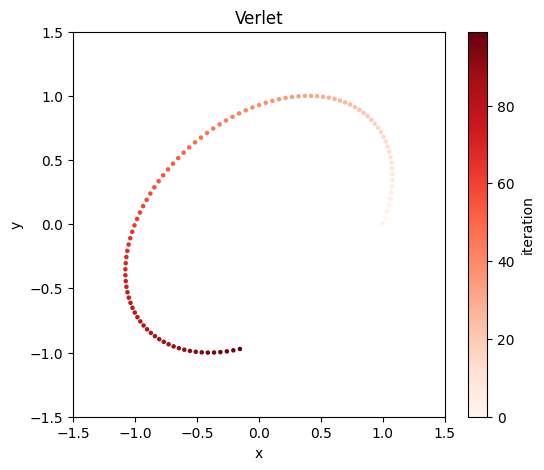

In [173]:
# Define a force 
F = lambda x : -x
dFdx = lambda x : -1

# initial position and velocity
x0 = np.array([1, 0])
v0 = np.array([0.4, 1])

x, v, P_cache = simulate(x0, v0, F, None, 100, 0.05)

display(P_cache, "Verlet")

### Inverse Problem

Let us now try to solve the inverse problem of finding the initial state $s_0$ given a desired endstate $s^*_n$:

In [174]:
# Define a force 
F = lambda x : -x
dFdx = lambda x : -1

# Make a guess for initial position and velocity
x0_guess = np.array([-0.2, -0.5], dtype=np.float32)
v0_guess = np.array([1, 0], dtype=np.float32)

xn_star = np.array([1, 1], dtype=np.float32)
vn_star = np.array([0, 1], dtype=np.float32)

n_iterations = 100
dt = 0.03


A visual inspection of the setup shows how the trajectory of the initial state $s_0$ is far away from the desired endstate $s^*_n$ when simulated forward in time.

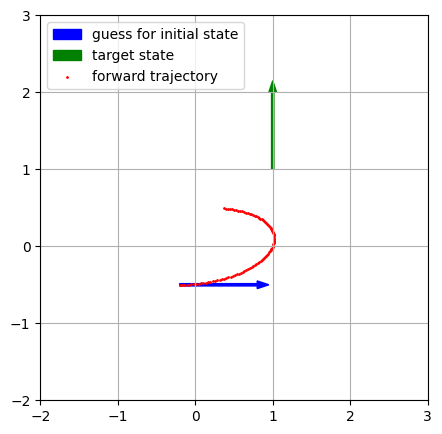

In [175]:
x, v, P_cache = simulate(x0_guess, v0_guess, F, None, n_iterations, 0.03)

plt.figure(figsize=(5,5))
plt.grid()

plt.xlim(-2, 3)
plt.ylim(-2, 3)

plt.arrow(x0_guess[0], x0_guess[1], v0_guess[0], v0_guess[1], color="blue", width=0.03, head_width=0.1)
plt.arrow(xn_star[0], xn_star[1], vn_star[0], vn_star[1], color="green", width=0.03, head_width=0.1)

xs, _, t = get_timeline(P_cache)
plt.scatter(xs[:,0], xs[:,1], c="red", s=1, marker="o")

plt.legend(["guess for initial state", "target state", "forward trajectory"])

To quantify the distance between the simulated endstate and the desired endstate we use the squared distance as loss function. Using the loss we have all the ingredients to compute the gradient of the loss with respect to the initial state $s_0$. This allows us to use gradient descent to iteratively improve the initial state $s_0$.

In [176]:
class Loss:

    def forward(self, truth : np.ndarray, pred : np.ndarray) -> float:
        self.truth_cache = truth.copy()
        self.pred_cache = pred.copy()
        return np.mean((truth - pred) ** 2)
    
    def backward(self) -> np.ndarray:
        n = self.truth_cache.size
        return (self.pred_cache - self.truth_cache) * 2 /n

Text(0, 0.5, 'loss')

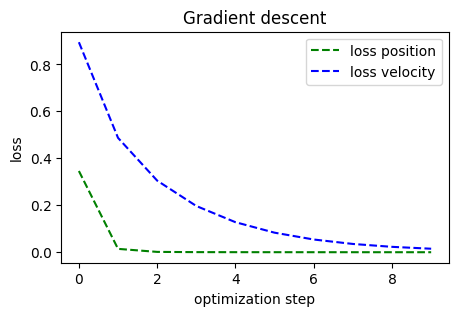

In [179]:

x0 = x0_guess.copy()
v0 = v0_guess.copy()

learning_rate_x = 0.2
learning_rate_v = 4.0
optimization_steps = 10

trajectories = np.zeros((optimization_steps, n_iterations, 2))
velocities = np.zeros((optimization_steps, n_iterations, 2))

losses_x = np.zeros(optimization_steps)
losses_v = np.zeros(optimization_steps)


for i in range(optimization_steps):
    
    xn, vn, P_cache = simulate(x0, v0, F, dFdx, n_iterations, dt)
    
    xs, vs, t = get_timeline(P_cache)
    trajectories[i,:,:] = xs
    velocities[i,:,:] = vs

    loss_x = Loss()
    loss_v = Loss()
    lx = loss_x.forward(xn_star ,xn)
    lv = loss_v.forward(vn_star, vn)

    losses_x[i] = lx
    losses_v[i] = lv

    grad_lx_p1 = loss_x.backward()
    grad_lv_p1 = loss_v.backward() 

    for P in reversed(P_cache):
        dPdx_x, dPdx_v = P.d_dx(grad_lx_p1, grad_lv_p1)
        dPdv_x, dPdv_v = P.d_dv(grad_lx_p1, grad_lv_p1)

        grad_lx_p1 = dPdx_x + dPdv_x
        grad_lv_p1 = dPdx_v + dPdv_v

    x0 += learning_rate_x * grad_lx_p1
    v0 += learning_rate_v * grad_lv_p1

plt.figure(figsize=(5,3))

plt.plot(losses_x, label="loss position", color="green", linestyle="dashed")
plt.plot(losses_v, label="loss velocity", color="blue", linestyle="dashed")

plt.legend()

plt.title("Gradient descent")
plt.xlabel("optimization step")
plt.ylabel("loss")


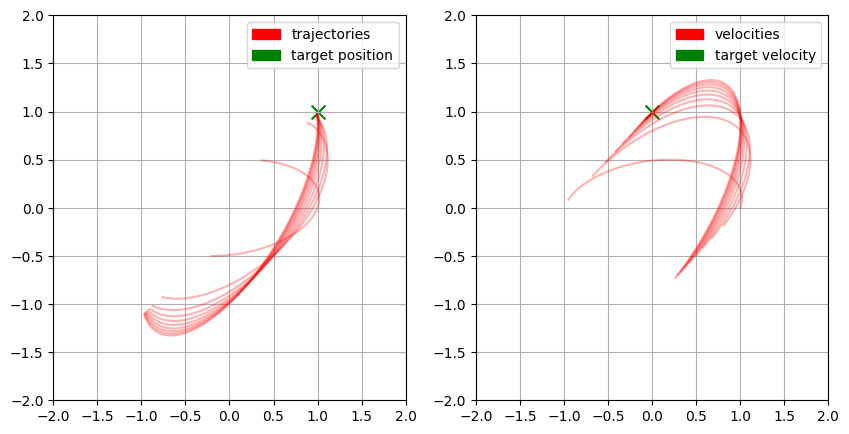

In [134]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
cmap = plt.get_cmap("Reds")

# Plot the trajectories
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-2, 2)
axs[0].grid()

axs[0].scatter(xn_star[0], xn_star[1], c="green", s=100, marker="x")    

red_patch = mpatches.Patch(color='red', label='trajectories')
green_patch = mpatches.Patch(color='green', label='target position')

handles = [red_patch, green_patch]
for i in range(optimization_steps):
    axs[0].plot(trajectories[i,:,0], trajectories[i,:,1], alpha=0.3, color="red")
axs[0].legend(handles=handles)

# Plot the velocities
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-2, 2)
axs[1].grid()

axs[1].scatter(vn_star[0], vn_star[1], c="green", s=100, marker="x")

red_patch = mpatches.Patch(color='red', label='velocities')
green_patch = mpatches.Patch(color='green', label='target velocity')
handles = [red_patch, green_patch]

for i in range(optimization_steps):
    axs[1].plot(velocities[i,:,0], velocities[i,:,1], alpha=0.3, color="red")
axs[1].legend(handles=handles)


### Fitting multiple points

To fit multiple points we ignore any velocity constraints and only fit the position.

In [135]:
# Define a force 
F = lambda x : -x
dFdx = lambda x : -1

# Make a guess for initial position and velocity
x0_guess = np.array([1.5, -0.5], dtype=np.float32)
v0_guess = np.array([0, 1.5], dtype=np.float32)

target_positions = [
    np.array([1, 0.5], dtype=np.float32),
    np.array([0.5, 1], dtype=np.float32),
]

target_iterations = [50, 100]
delta_iterations = [50, 50]

n_iterations = max(target_iterations)
n_targets = len(target_iterations)
dt = 0.03

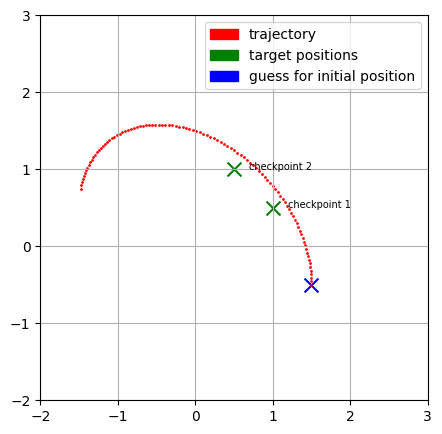

In [136]:
x, v, P_cache = simulate(x0_guess, v0_guess, F, None, n_iterations, dt)

plt.figure(figsize=(5,5))
plt.grid()

plt.xlim(-2, 3)
plt.ylim(-2, 3)

for i in range(len(target_iterations)):
    plt.scatter(target_positions[i][0], target_positions[i][1], c="green", s=100, marker="x")
    # add text to the point
    plt.text(target_positions[i][0]+0.2, target_positions[i][1], f"checkpoint {i+1}", fontsize=7)

plt.scatter(x0_guess[0], x0_guess[1], c="blue", s=100, marker="x")

xs, _, t = get_timeline(P_cache)
plt.scatter(xs[:,0], xs[:,1], c="red", s=1, marker="o")

red_patch = mpatches.Patch(color='red', label='trajectory')
green_patch = mpatches.Patch(color='green', label='target positions')
blue_patch = mpatches.Patch(color='blue', label='guess for initial position')
handles = [red_patch, green_patch, blue_patch]

plt.legend(handles=handles)

Although there is most likely no configuration of the initial state $s_0$ that will fit all the points, we can still try to find a configuration that minimizes the overall loss.

target position [1.  0.5] - actual position [0.15085635 1.44227719]
target position [0.5 1. ] - actual position [-1.47800052  0.7486583 ]
target position [1.  0.5] - actual position [0.14250658 1.45154285]
target position [0.5 1. ] - actual position [-1.39619291  0.65787888]
target position [1.  0.5] - actual position [0.13407464 1.46089911]
target position [0.5 1. ] - actual position [-1.31358194  0.56620717]
target position [1.  0.5] - actual position [0.12555958 1.47034836]
target position [0.5 1. ] - actual position [-1.23015726  0.47363323]
target position [1.  0.5] - actual position [0.11696126 1.47989035]
target position [0.5 1. ] - actual position [-1.14591336  0.38014933]
target position [1.  0.5] - actual position [0.10827773 1.48952532]
target position [0.5 1. ] - actual position [-1.06084085  0.28574637]
target position [1.  0.5] - actual position [0.09950933 1.49925613]
target position [0.5 1. ] - actual position [-0.9749319   0.19041507]
target position [1.  0.5] - actual

Text(0, 0.5, 'loss')

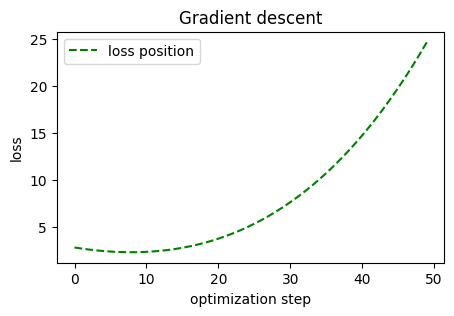

In [137]:

x0 = x0_guess.copy()
v0 = v0_guess.copy()

learning_rate = 0.1
optimization_steps = 50

trajectories = np.zeros((optimization_steps, n_iterations, 2))
velocities = np.zeros((optimization_steps, n_iterations, 2))

losses_x = np.zeros(optimization_steps)

for i in range(optimization_steps):

    xn, vn, P_cache = simulate(x0, v0, F, dFdx, n_iterations, dt)
    xs, vs, t = get_timeline(P_cache)
    
    trajectories[i,:,:] = xs
    velocities[i,:,:] = vs

    grads_x = [
        np.zeros(2),
        np.zeros(2)
    ]

    grads_v = [
        np.zeros(2),
        np.zeros(2)
    ]

    running_loss = 0

    for j in range(len(target_iterations)):
        loss_x = Loss()
        lx = loss_x.forward(target_positions[j], xs[target_iterations[j]-1])
        print(f"target position {target_positions[j]} - actual position {xs[target_iterations[j]-1]}")
        running_loss += lx
        grads_x[j] = loss_x.backward()

        for k in reversed(range(target_iterations[j])):
            P = P_cache[k]
            grads_x[j], grads_v[j] = P.d_dx(grads_x[j],  grads_v[j] )

    losses_x[i] = running_loss
    x0 += learning_rate * grads_x[0]
    v0 += learning_rate * grads_v[0]

plt.figure(figsize=(5,3))

plt.plot(losses_x, label="loss position", color="green", linestyle="dashed")

plt.legend()

plt.title("Gradient descent")
plt.xlabel("optimization step")
plt.ylabel("loss")


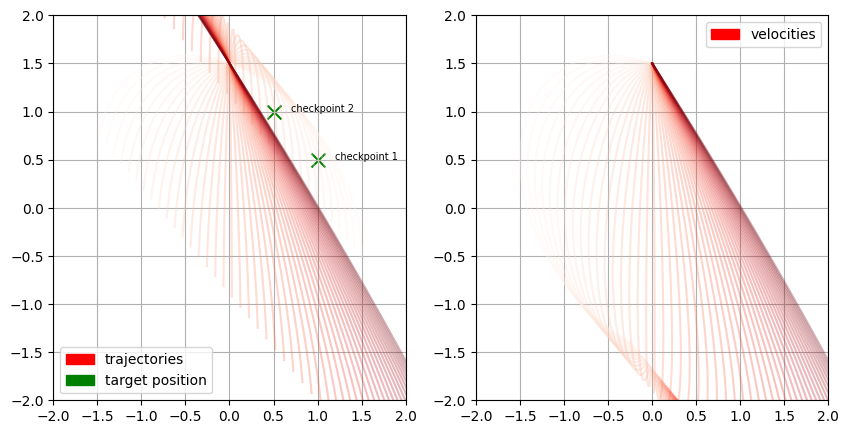

In [138]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
cmap = plt.get_cmap("Reds")

# Plot the trajectories
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-2, 2)
axs[0].grid()

for i in range(len(target_iterations)):
    axs[0].scatter(target_positions[i][0], target_positions[i][1], c="green", s=100, marker="x")
    # add text to the point
    axs[0].text(target_positions[i][0]+0.2, target_positions[i][1], f"checkpoint {i+1}", fontsize=7)


red_patch = mpatches.Patch(color='red', label='trajectories')
green_patch = mpatches.Patch(color='green', label='target position')

handles = [red_patch, green_patch]
for i in range(optimization_steps):
    axs[0].plot(trajectories[i,:,0], trajectories[i,:,1], alpha=0.3, color=cmap(i/optimization_steps))
axs[0].legend(handles=handles)

# Plot the velocities
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-2, 2)
axs[1].grid()

red_patch = mpatches.Patch(color='red', label='velocities')
handles = [red_patch]

for i in range(optimization_steps):
    axs[1].plot(velocities[i,:,0], velocities[i,:,1], alpha=0.3, color=cmap(i/optimization_steps))
axs[1].legend(handles=handles)


### More complex force fields

To proove that the method works, we use a more complex force field where we have $K$ attractors with positions $k_i$. The force field is defined as:

$$ F(x) = \sum_{i=1}^N \frac{k_i - x}{||k_i - x||^2} $$

Finding the derivate of the force field is a bit more involved but it is still possible to do it analytically. However we will skip this step and simply use an autograd library to get the gradient of the loss of the solver. Therefore we reimplemnt the solver using the jax library.



In [15]:
import numpy as np
from typing import Callable
import jax.numpy as jnp
from jax import value_and_grad

def force(x, attractors : np.ndarray):
    x_al = jnp.repeat(x.reshape(1,2), len(attractors), axis=0)
    vec = attractors - x_al

    d = jnp.sqrt(jnp.sum(vec ** 2, axis=1))

    f = jnp.sum(vec / d.reshape(-1,1), axis=0)

    return f

def forward(x : np.ndarray, v : np.ndarray, dt : float, m : float, force : Callable, attractors : np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    dt2 = jnp.square(dt)
    x_fwd = x + v * dt + 0.5 * force(x, attractors) / m * dt2
    v_fwd = v + 0.5 * (force(x, attractors) + force(x_fwd, attractors)) * dt / m

    return x_fwd, v_fwd

def simulation_loss_x(
        x0 : np.ndarray, 
        v0 : np.ndarray, 
        xn_star : np.ndarray,
        dt : float, 
        n : int, 
        m : float, 
        force : Callable, 
        attractors : np.ndarray) -> float:
    x = x0.copy()
    v = v0.copy()
    for i in range(n):
        x, v = forward(x, v, dt, m, force, attractors)
    loss = jnp.sum(jnp.square(x - xn_star))

    return loss
    
loss_grad = value_and_grad(simulation_loss_x, argnums=(0))
   

In [19]:
x0 = np.array([0.0, 0.0])
v0 = np.array([0.0, 0.0])

xn_star = np.array([0.5, 1.0])

n_iterations = 50
dt = 0.1
m = 1.0

n_attractors = 10

optimization_steps = 30

attractors = np.random.random((n_attractors, 2)) * 2 - 1
learning_rate = 0.02
for i in range(optimization_steps):

    loss, grad =  loss_grad(x0, v0, xn_star, dt, n_iterations, m, force, attractors)

    x0 -= learning_rate * grad

    print(F"loss {loss}")




loss 2.4416451454162598
loss 2.2878963947296143
loss 2.9877731800079346
loss 2.0229568481445312
loss 1.9777491092681885
loss 1.9631390571594238
loss 1.9549801349639893
loss 2.0051023960113525
loss 2.0372164249420166
loss 2.0318362712860107
loss 1.9510321617126465
loss 1.9436564445495605
loss 1.9940593242645264
loss 2.109086036682129
loss 2.2078909873962402
loss 2.2495832443237305
loss 2.023153305053711
loss 1.952633261680603
loss 1.9336155652999878
loss 1.9305490255355835
loss 1.9807337522506714
loss 2.1680774688720703
loss 1.9821596145629883
loss 1.9413747787475586
loss 1.9275720119476318
loss 1.9215394258499146
loss 1.919428825378418
loss 1.9196202754974365
loss 1.9235068559646606
loss 1.9947004318237305


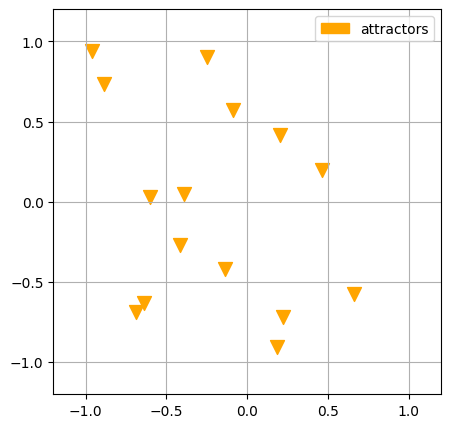

In [157]:


plt.figure(figsize=(5,5))
plt.grid()

plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)

for i in range(n_attractors):
    plt.scatter(attractors[i,0], attractors[i,1], c="orange", s=100, marker="v")

handles = [mpatches.Patch(color='orange', label='attractors')]
plt.legend(handles=handles)


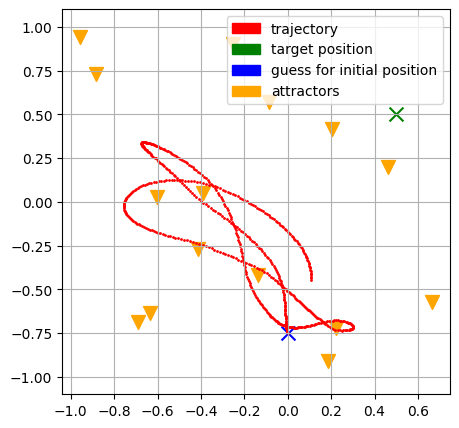

In [169]:
x0_guess = np.array([0., -0.75])
v0_guess = np.array([-0.2, 0.5])

xn_star = np.array([0.5, 0.5])

n_iterations = 600

x, v, P_cache = simulate(x0_guess, v0_guess, F_attr, None, n_iterations, 0.005)
xs, vs, ts = get_timeline(P_cache)

plt.figure(figsize=(5,5))
plt.grid()

plt.ylim(-1.1, 1.1)

xs, _, t = get_timeline(P_cache)
for i in range(n_attractors):
    plt.scatter(attractors[i,0], attractors[i,1], c="orange", s=100, marker="v")

plt.scatter(x0_guess[0], x0_guess[1], c="blue", s=100, marker="x")
plt.scatter(xn_star[0], xn_star[1], c="green", s=100, marker="x")
plt.scatter(xs[:,0], xs[:,1], c="red", s=1, marker="o")

orange_patch = mpatches.Patch(color='orange', label='attractors')
red_patch = mpatches.Patch(color='red', label='trajectory')
green_patch = mpatches.Patch(color='green', label='target position')
blue_patch = mpatches.Patch(color='blue', label='guess for initial position')
handles = [red_patch, green_patch, blue_patch, orange_patch]

plt.legend(handles=handles)


In [152]:

x0 = x0_guess.copy()
v0 = v0_guess.copy()

learning_rate = 0.2
optimization_steps = 10

trajectories = np.zeros((optimization_steps, n_iterations, 2))
velocities = np.zeros((optimization_steps, n_iterations, 2))

losses_x = np.zeros(optimization_steps)

for i in range(optimization_steps):

    xn, vn, P_cache = simulate(x0, v0, F_attr, dFdx_attr, n_iterations, dt)
    xs, vs, t = get_timeline(P_cache)
    
    trajectories[i,:,:] = xs
    velocities[i,:,:] = vs

    rev_sim_step = n_iterations - 1
    grad_lx_p1 = np.zeros(2)
    grad_lv_p1 = np.zeros(2)

    prev_target_iteration = 0

    for j in reversed(range(len(target_iterations))):
        
        loss_x = Loss()

        lx = loss_x.forward(target_positions[j], xs[target_iterations[j]-1])

        losses_x[i] += lx

        grad_lx_p1 += 0.5 *  loss_x.backward()

        for k in range(delta_iterations[j]):
            rev_sim_step -= 1
            P = P_cache[rev_sim_step]
            grad_lx_p1, grad_lv_p1 = P.d_dx(grad_lx_p1, grad_lv_p1)

    x0 += learning_rate * grad_lx_p1
    v0 += learning_rate * grad_lv_p1

plt.figure(figsize=(5,3))

plt.plot(losses_x, label="loss position", color="green", linestyle="dashed")

plt.legend()

plt.title("Gradient descent")
plt.xlabel("optimization step")
plt.ylabel("loss")


KeyboardInterrupt: 